In [ ]:
!pip install nvcc4jupyter
%load_ext nvcc4jupyter

Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmpuozikp1m".


In [ ]:
# Detect selected GPU and its NVIDA architecture:
import subprocess
gpu_info = subprocess.getoutput("nvidia-smi --query-gpu=name,compute_cap --format=csv,noheader,nounits")
if "not found" in gpu_info.lower(): raise RuntimeError("Error: No GPU found. Please select a GPU runtime environment.")
gpu_name, compute_cap = map(str.strip, gpu_info.split(','))
gpu_arch = f"sm_{compute_cap.replace('.', '')}"

print(f"{'GPU Name':<15}: {gpu_name}")
print(f"{'Architecture':<15}: {gpu_arch}")

GPU Name       : NVIDIA A100-SXM4-40GB
Architecture   : sm_80


In [ ]:
%%cuda -c "--gpu-architecture $gpu_arch"
#include <stdio.h>
#include <cstdlib>
#include <cassert>
#include <iostream>
#include <cuda_runtime.h>

__global__ void matrixMulKernel(int *a, int *b, int *c, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    int temp = 0;
    if (row < N && col < N){
        for (int i = 0; i < N; ++i){
            temp += a[row * N + i] * b[i * N + col];
        }
    }
    c[row * N + col] = temp;
}

float verify_result(int *a, int *b, int *c, int N)
{

    for (int i = 0; i < N; ++i)
    {
        for (int j = 0; j < N; ++j)
        {
            int temp = 0;
            for (int k = 0; k < N; ++k)
            {
                temp += a[i * N + k] * b[k * N + j];
            }

            assert(temp == c[i * N + j]);
        }
    }

}

void init_matrix(int *m, int N)
{
    for (int i = 0; i < N * N; ++i)
    {
        m[i] = rand() % 100;
    }
}


int main() {
    int N = 1 << 10;
    size_t bytes = N * N * sizeof(int);

    int *a, *b, *c;
    cudaMallocManaged(&a, bytes);
    cudaMallocManaged(&b, bytes);
    cudaMallocManaged(&c, bytes);

    init_matrix(a, N);
    init_matrix(b, N);

    int threads = 16;
    int blocks = (N + threads - 1) / threads;

    dim3 THREADS(threads, threads);
    dim3 BLOCKS(blocks, blocks);

    matrixMulKernel<<<BLOCKS, THREADS>>>(a, b, c, N);
    cudaDeviceSynchronize();

    //verify_result(a, b, c, N);

    std::cout << "PROGRAM COMPLETED" << std::endl;

    return 0;
}

PROGRAM COMPLETED



# Testing time with multiple matrix sizes

In [ ]:
%%cuda -c "--gpu-architecture $gpu_arch"
#include <stdio.h>
#include <cstdlib>
#include <cassert>
#include <iostream>
#include <chrono>
#include <vector>
#include <cuda_runtime.h>

__global__ void matrixMulKernel(int *a, int *b, int *c, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    int temp = 0;
    if (row < N && col < N){
        for (int i = 0; i < N; ++i){
            temp += a[row * N + i] * b[i * N + col];
        }
    }
    c[row * N + col] = temp;
}


// Function to carry out matrix multiplication on CPU
float cpu_mm_time(int *a, int *b, int *c, int N)
{
    auto start = std::chrono::high_resolution_clock::now();

    for (int i = 0; i < N; ++i)
    {
        for (int j = 0; j < N; ++j)
        {
            int temp = 0;
            for (int k = 0; k < N; ++k)
            {
                temp += a[i * N + k] * b[k * N + j];
            }

            c[i * N + j] = temp;
        }
    }

    auto stop = std::chrono::high_resolution_clock::now();
    std::chrono::duration<float, std::milli> duration = stop - start;
    return duration.count();
}

void init_matrix(int *m, int N)
{
    for (int i = 0; i < N * N; ++i)
    {
        m[i] = rand() % 100;
    }
}

// Function to calculate GPU Time
float gpu_mm_time(int *a, int *b, int *c, int N){
    size_t bytes = N * N * sizeof(int);

    int threads = 16;
    int blocks = (N + threads - 1) / threads;
    dim3 THREADS(threads, threads);
    dim3 BLOCKS(blocks, blocks);

    // Creating CUDA Events
    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    // Start recording
    cudaEventRecord(start);

    matrixMulKernel<<<BLOCKS, THREADS>>>(a, b, c, N); // Matrix Multiplication occurs
    cudaDeviceSynchronize();

    // Stop recording
    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    // Saving time
    float t_ms = 0;
    cudaEventElapsedTime(&t_ms, start, stop);


    // Freeing used memory
    cudaEventDestroy(start);
    cudaEventDestroy(stop);
    cudaDeviceSynchronize();

    return t_ms;

}

int main(){
    std::vector<int> sizes;
    for (int i = 0; i < 12; ++i){
        sizes.push_back(1 << i);
    }
    std::vector<float> gpu_times, cpu_times;

    for (int N : sizes) {
        size_t bytes = N * N * sizeof(int);
        int *a, *b, *c;
        cudaMallocManaged(&a, bytes);
        cudaMallocManaged(&b, bytes);
        cudaMallocManaged(&c, bytes);

        init_matrix(a, N);
        init_matrix(b, N);

        float gpu_time = gpu_mm_time(a, b, c, N);
        float cpu_time = cpu_mm_time(a, b, c, N);

        gpu_times.push_back(gpu_time);
        cpu_times.push_back(cpu_time);

        printf("N=%d | GPU=%.2f ms | CPU=%.2f ms\n", N, gpu_time, cpu_time);

        cudaFree(a);
        cudaFree(b);
        cudaFree(c);
    }

}





N=1 | GPU=0.27 ms | CPU=0.06 ms
N=2 | GPU=0.11 ms | CPU=0.05 ms
N=4 | GPU=0.10 ms | CPU=0.04 ms
N=8 | GPU=0.10 ms | CPU=0.04 ms
N=16 | GPU=0.09 ms | CPU=0.05 ms
N=32 | GPU=0.11 ms | CPU=0.14 ms
N=64 | GPU=0.14 ms | CPU=0.81 ms
N=128 | GPU=0.29 ms | CPU=7.17 ms
N=256 | GPU=0.56 ms | CPU=56.97 ms
N=512 | GPU=1.10 ms | CPU=539.01 ms
N=1024 | GPU=3.75 ms | CPU=7383.97 ms
N=2048 | GPU=18.23 ms | CPU=90395.02 ms



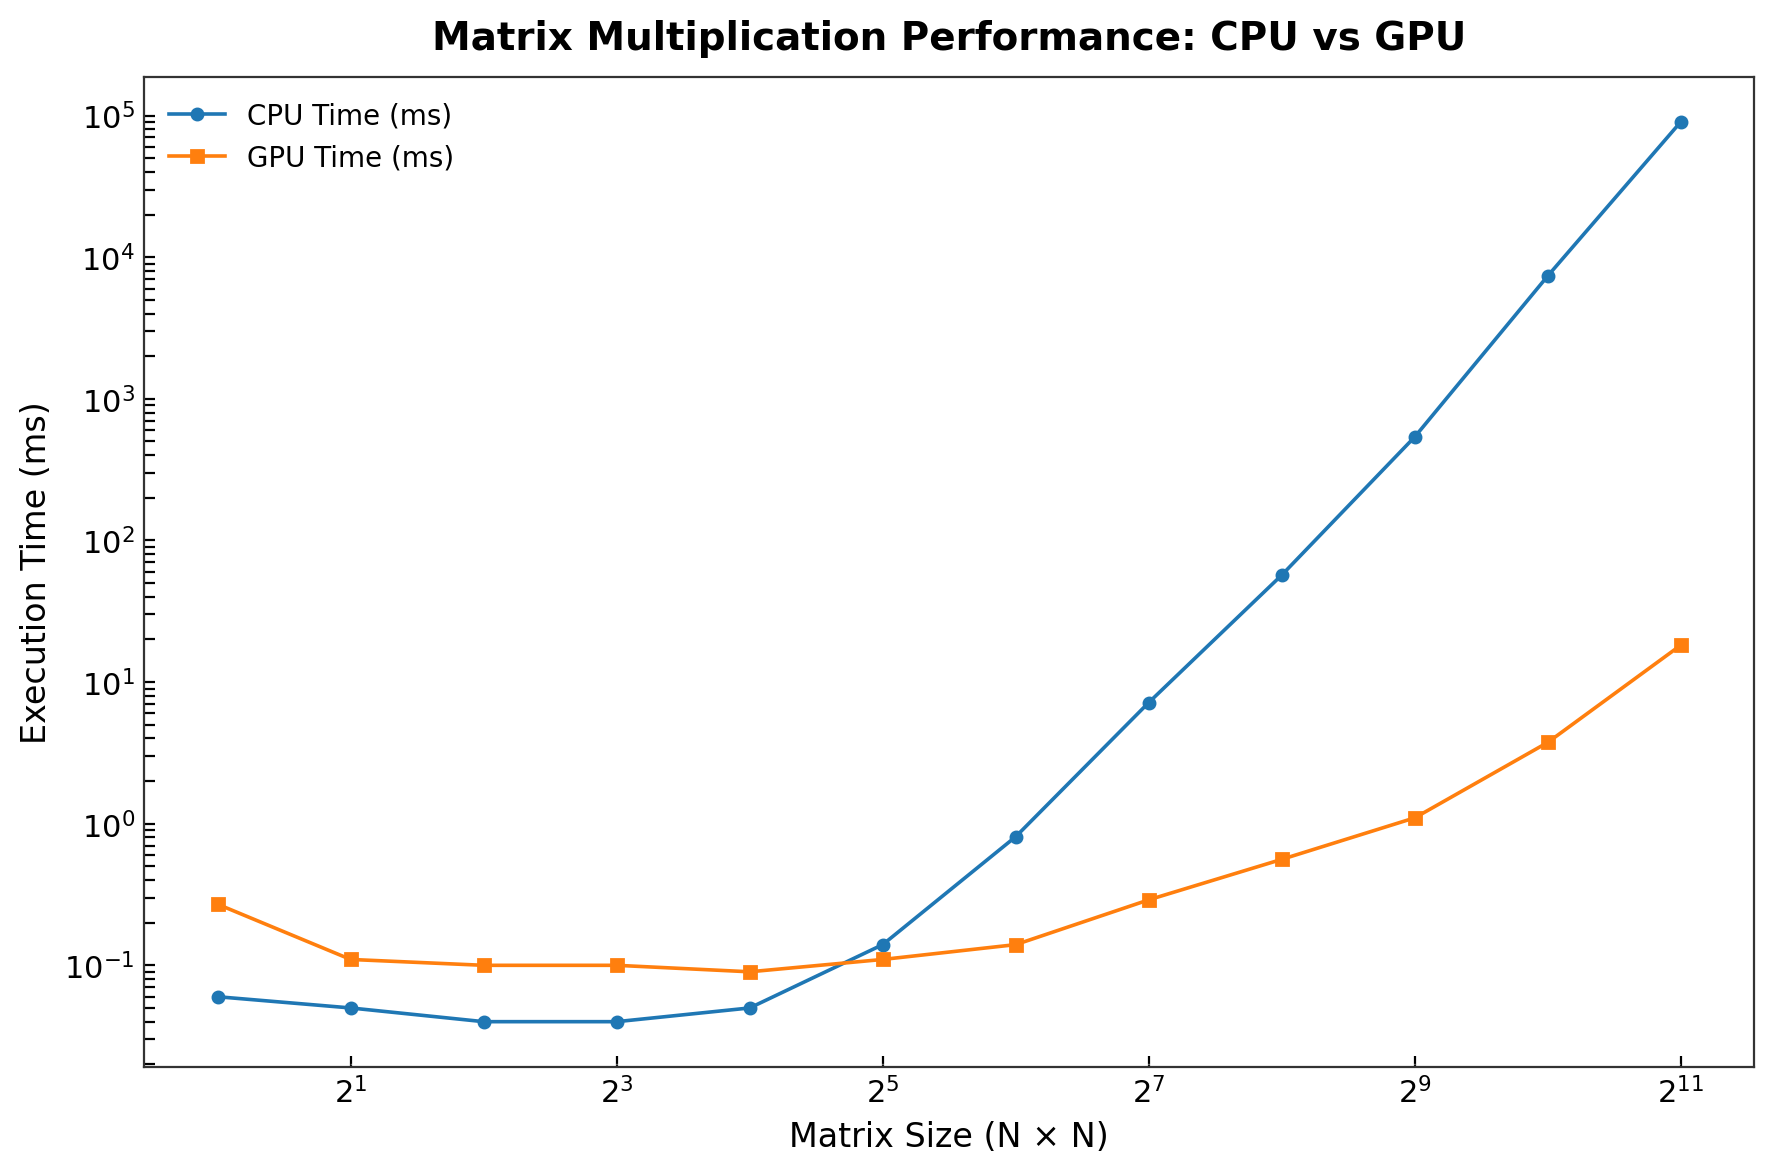

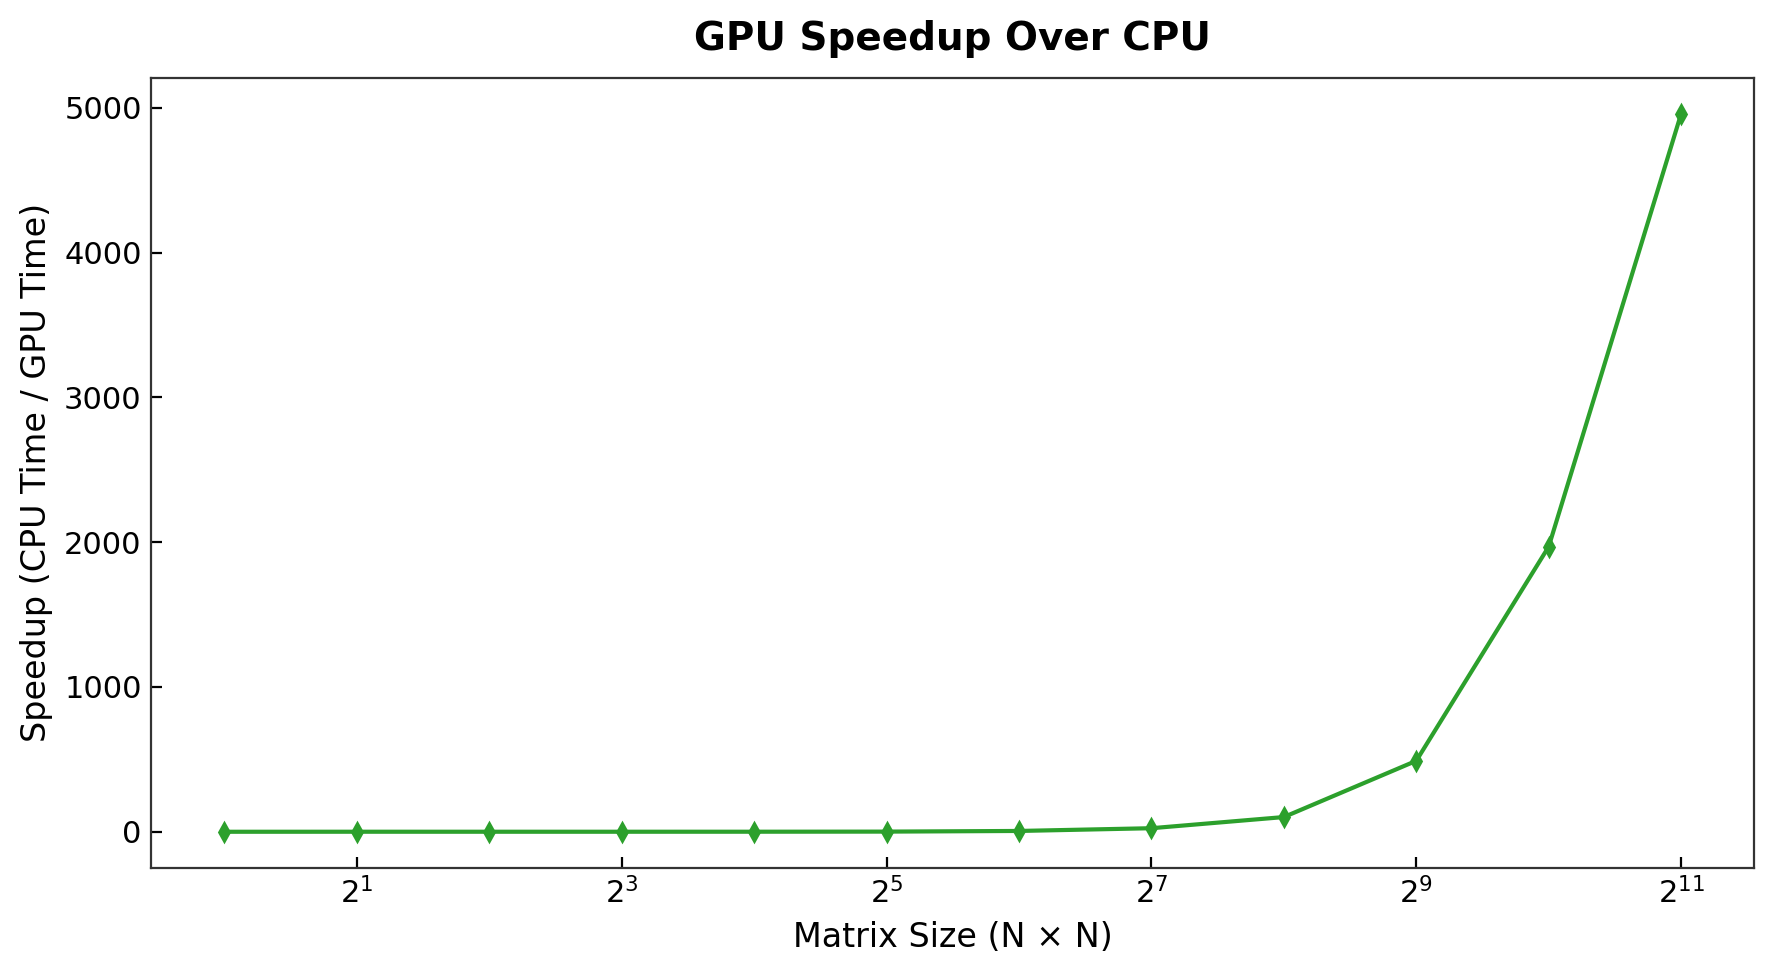

In [ ]:
import matplotlib.pyplot as plt

# Hard coding data from test runs
N = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
gpu_time = [0.27, 0.11, 0.10, 0.10, 0.09, 0.11, 0.14, 0.29, 0.56, 1.10, 3.75, 18.23]
cpu_time = [0.06, 0.05, 0.04, 0.04, 0.05, 0.14, 0.81, 7.17, 56.97, 539.01, 7383.97, 90395.02]

# Calculate GPU speedup ratio
speedup = [c / g for c, g in zip(cpu_time, gpu_time)]


# Some cool settings I found for a sleeker graph design lol
plt.rcParams.update({
    'figure.dpi': 200,
    'font.family': 'DejaVu Sans',
    'font.size': 11,
    'axes.edgecolor': '#333333',
    'axes.linewidth': 0.8,
    'lines.linewidth': 1.3,
    'grid.linewidth': 0.5,
    'grid.alpha': 0.4,
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'axes.labelcolor': 'black',
    'text.color': 'black'
})

# Define neutral color palette
cpu_color = '#1f77b4'   # Blue
gpu_color = '#ff7f0e'   # Orange
speedup_color = '#2ca02c'  # Green

# Execution Time Graph
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(N, cpu_time, 'o-', color=cpu_color, label='CPU Time (ms)', markersize=4)
ax.plot(N, gpu_time, 's-', color=gpu_color, label='GPU Time (ms)', markersize=4)

ax.set_xscale('log', base=2)
ax.set_yscale('log')
ax.set_xlabel("Matrix Size (N × N)", fontsize=12)
ax.set_ylabel("Execution Time (ms)", fontsize=12)
ax.set_title("Matrix Multiplication Performance: CPU vs GPU", fontsize=14, weight='bold', pad=10)

ax.grid(True, which='both', linestyle='--')
ax.legend(fontsize=10, loc='upper left', frameon=False)
ax.tick_params(which='both', direction='in', length=4, width=0.8)

plt.tight_layout()
plt.show()


# Speedup (Ratio)
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(N, speedup, 'd-', color=speedup_color, linewidth=1.5, markersize=4.5)

ax.set_xscale('log', base=2)
ax.set_xlabel("Matrix Size (N × N)", fontsize=12)
ax.set_ylabel("Speedup (CPU Time / GPU Time)", fontsize=12)
ax.set_title("GPU Speedup Over CPU", fontsize=14, weight='bold', pad=10)

ax.grid(True, which='both', linestyle='--')
ax.tick_params(which='both', direction='in', length=4, width=0.8)

plt.tight_layout()
plt.show()